In [1]:
from kan_convs import FastKANConv1DLayer
from kans import FastKAN
import numpy as np
import torch
import torch.nn as nn

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\Ninh Tri\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\cuda\__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = FastKANConv1DLayer(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = FastKAN([out_channels])
        self.conv2 = FastKANConv1DLayer(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [4]:
class ResNet1D(nn.Module):
    def __init__(self, block, layers, num_classes=5):
        super(ResNet1D, self).__init__()
        self.in_channels = 64
        self.conv1 = FastKANConv1DLayer(1, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = FastKAN([64])
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = FastKAN([512, num_classes])

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                FastKANConv1DLayer(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [5]:
model = ResNet1D(BasicBlock, [2, 2, 2, 2])

In [12]:
dict(model.named_modules())

{'': ResNet1D(
   (conv1): FastKANConv1DLayer(
     (base_activation): SiLU()
     (base_conv): ModuleList(
       (0): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
     )
     (spline_conv): ModuleList(
       (0): Conv1d(8, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
     )
     (layer_norm): ModuleList(
       (0): InstanceNorm1d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
     )
     (rbf): RadialBasisFunction()
   )
   (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): FastKAN(
     (layers): ModuleList()
   )
   (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): FastKANConv1DLayer(
         (base_activation): SiLU()
         (base_conv): ModuleList(
           (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
         )
         (spline_conv): 

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.collections as mcoll
import cv2

In [168]:
def multicolored_lines(x, y, heatmap, title_name):
    fig, ax = plt.subplots()
    lc = colorline(x, y, heatmap, cmap='rainbow')
    plt.colorbar(lc)
    lc.set_linewidth(2)
    lc.set_alpha(0.8)
    plt.xlim(x.min(), x.max())
    plt.ylim(np.min(y), np.max(y))  # Adjust ylim based on y values
    plt.title(title_name)
    plt.grid(False)
    plt.show()

def colorline(x, y, heatmap, cmap='rainbow'):
    z = np.array(heatmap)
    points = np.column_stack((x, y))
    segments = np.stack([points[:-1], points[1:]], axis=1)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap)
    ax = plt.gca()
    ax.add_collection(lc)
    return lc

def compute_cam_1d_output(model, data, layer_name, N):
    """
    model: The Deep Learning model
    data : A input data. Data shape has to be (n,1,1)
    layer_name : The target layer for explanation
    N: signal length in seconds
    """
    # Setting the model to evaluation mode
    model.eval()
    
    # Extracting the target layer and output layer
    conv_outs = None
    grads = None

    def forward_hook(module, input, output):
        nonlocal conv_outs
        conv_outs = output
        output.requires_grad_(True)

    def backward_hook(module, grad_in, grad_out):
        nonlocal grads
        grads = grad_out[0]

    # Register hooks
    target_layer = dict(model.named_modules())[layer_name]
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_full_backward_hook(backward_hook)
    
    # Convert the input data to a tensor and expand dimensions to match expected input
    inputs = torch.tensor(data, dtype=torch.float32).unsqueeze(1).requires_grad_(True)
    
    # Forward pass to get model output
    predictions = model(inputs)
    class_idx = torch.argmax(predictions[0])
    y_c = predictions[:, class_idx]
    print(y_c, predictions)

    # Backward pass to get gradients
    model.zero_grad()
    y_c.backward(retain_graph=True)
    
    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    # Ensure gradients are available
    if grads is None:
        raise RuntimeError("Gradients are not available for conv_outs. Ensure conv_outs has requires_grad=True.")
    
    grads = grads[0]

    # Print shapes for debugging
    print("conv_outs shape:", conv_outs.shape)
    print("grads shape:", grads.shape)
    
    # First, second and third derivative of output gradient
    first = torch.exp(y_c) * grads
    second = torch.exp(y_c) * torch.pow(grads, 2)
    third = torch.exp(y_c) * torch.pow(grads, 3)
    
    print("first shape:", first.shape)
    print("second shape:", second.shape)
    print("third shape:", third.shape)

    # Compute saliency maps for the class_idx prediction
    global_sum = torch.sum(conv_outs[0].reshape(-1, first.shape[1]), dim=0)
    print("global_sum shape:", global_sum.shape)
    alpha_num = second
    alpha_denom = second * 2.0 + third * global_sum.reshape((1, 1, -1))
    alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))
    alphas = alpha_num / alpha_denom
    weights = torch.maximum(first, torch.tensor(0.0))
    alpha_normalization_constant = torch.sum(torch.sum(alphas, dim=0), dim=0)
    alphas /= alpha_normalization_constant.reshape((1, 1, -1))
    alphas_thresholding = torch.where(weights > 0, alphas, torch.tensor(0.0))

    alpha_normalization_constant = torch.sum(torch.sum(alphas_thresholding, dim=0), dim=0)
    alpha_normalization_constant_processed = torch.where(alpha_normalization_constant != 0.0, alpha_normalization_constant,
                                                         torch.ones_like(alpha_normalization_constant))

    alphas /= alpha_normalization_constant_processed.reshape((1, 1, -1))
    deep_linearization_weights = torch.sum((weights * alphas).reshape(-1, first.shape[1]), dim=0)
    grad_CAM_map = torch.sum(deep_linearization_weights * conv_outs[0], dim=-1)
    
    # Normalization
    cam = torch.maximum(grad_CAM_map, torch.tensor(0.0))
    cam = cam / torch.max(cam)  
    
    # Turn result into a heatmap
    heatmap = []
    heatmap.append(cam.detach().numpy().tolist())
    big_heatmap = cv2.resize(np.array(heatmap), dsize=(data.shape[1], 500), interpolation=cv2.INTER_CUBIC)
    x = np.linspace(0, N, data.shape[1])
    # print(len(big_heatmap[0]))
    plt.style.use("seaborn-v0_8-whitegrid")
    multicolored_lines(x, np.array([i for i in data])[0], big_heatmap[0], f"GradCAM++ Visualization")


In [169]:
data = torch.rand(1, 106)

C:\Users\Ninh Tri\AppData\Local\Temp\ipykernel_2860\500898072.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(data, dtype=torch.float32).unsqueeze(1).requires_grad_(True)


tensor([1.4704], grad_fn=<SelectBackward0>) tensor([[ 1.4123, -2.2623, -0.6039, -2.2441,  1.4704]], grad_fn=<AddBackward0>)
conv_outs shape: torch.Size([1, 512, 4])
grads shape: torch.Size([512, 4])
first shape: torch.Size([512, 4])
second shape: torch.Size([512, 4])
third shape: torch.Size([512, 4])
global_sum shape: torch.Size([4])


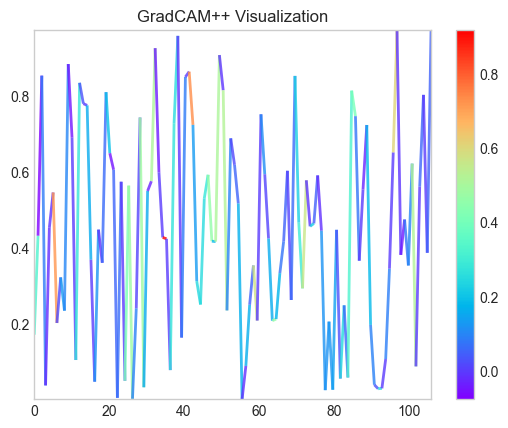

In [170]:
compute_cam_1d_output(model, data , 'layer4.1.conv2' , 106)